# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import deque


Обработка файла 0.xls...
Найдено кластеров: 2, шумовых точек: 16


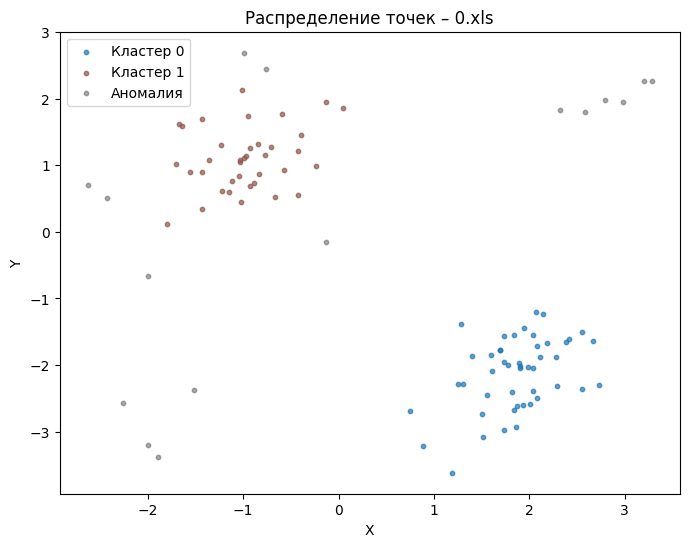

Кластер 0: центр. точка = [ 1.90546599 -2.04085179]
Кластер 1: центр. точка = [-0.99483344  1.11411203]
Среднее центроидов * 100000: X = 44399, Y = -51244

Обработка файла 1.xls...
Найдено кластеров: 2, шумовых точек: 12


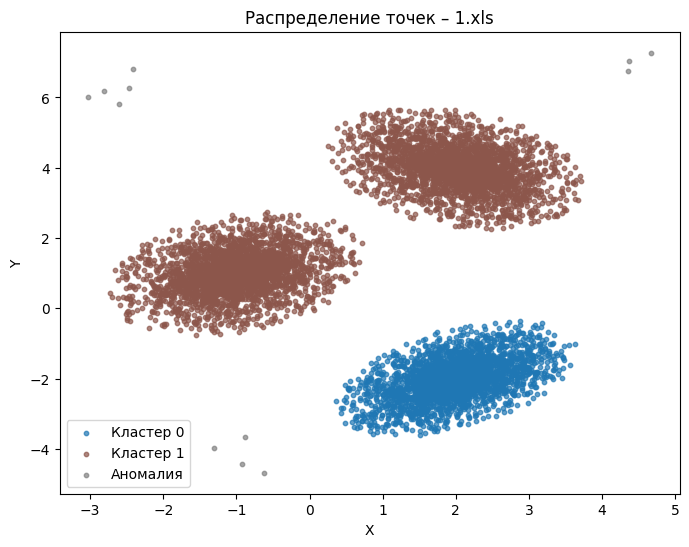

Кластер 0: центр. точка = [ 1.99791135 -1.99916426]
Кластер 1: центр. точка = [0.17957678 2.15140837]
Среднее центроидов * 100000: X = 124659, Y = 24805

Обработка файла 2.txt...
Найдено кластеров: 2, шумовых точек: 55


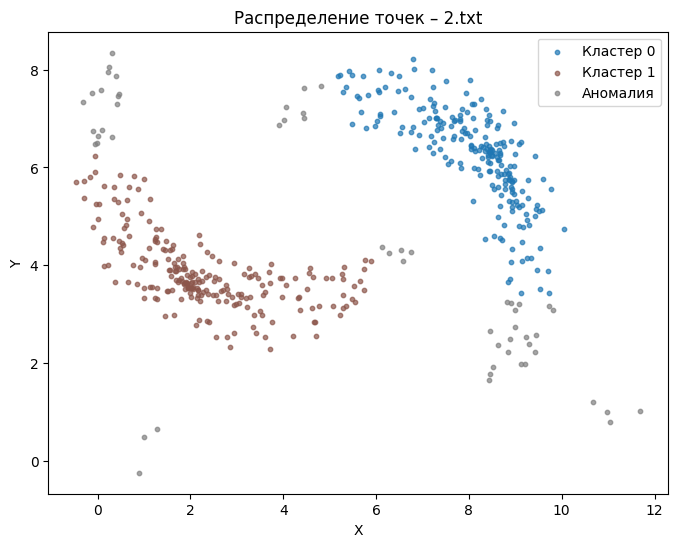

Кластер 0: центр. точка = [8.22687968 6.35738211]
Кластер 1: центр. точка = [2.09088854 3.66325727]
Среднее центроидов * 100000: X = 517837, Y = 505421

Обработка файла 3.txt...
Найдено кластеров: 3, шумовых точек: 12


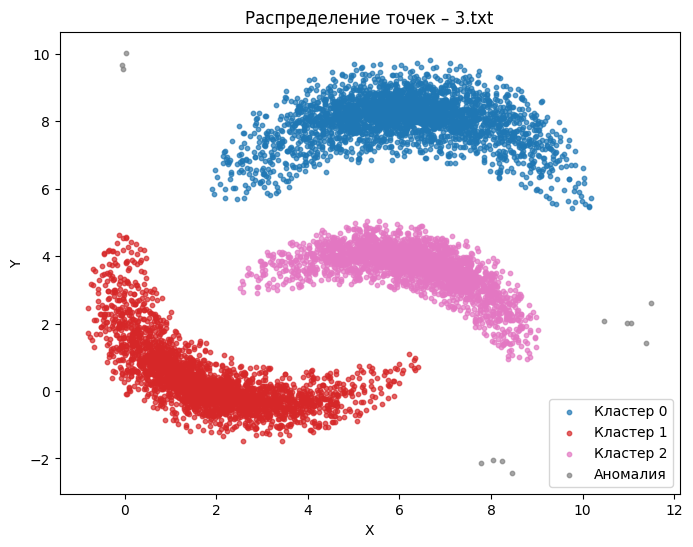

Кластер 0: центр. точка = [6.09727603 8.29044994]
Кластер 1: центр. точка = [1.69615102 0.12926251]
Кластер 2: центр. точка = [6.33889118 3.85633299]
Среднее центроидов * 100000: X = 472968, Y = 404287

Обработка файла 4.txt...
Найдено кластеров: 2, шумовых точек: 16


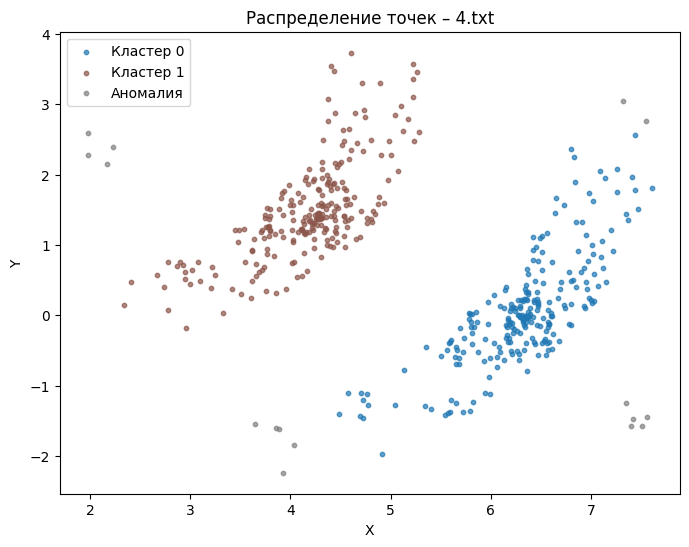

Кластер 0: центр. точка = [ 6.34537950e+00 -6.18192182e-03]
Кластер 1: центр. точка = [4.24476995 1.43145812]
Среднее центроидов * 100000: X = 524576, Y = 77416

Обработка файла 5.txt...
Найдено кластеров: 3, шумовых точек: 12


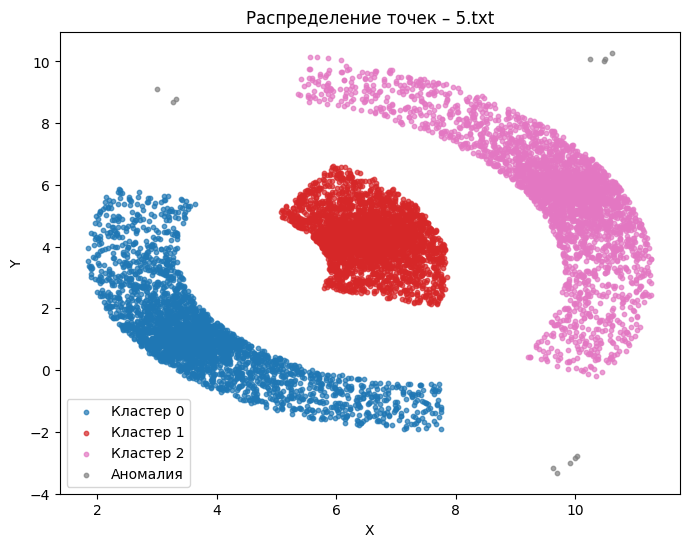

Кластер 0: центр. точка = [3.58369201 0.99978374]
Кластер 1: центр. точка = [6.63243918 4.2921765 ]
Кластер 2: центр. точка = [9.88226828 5.82908407]
Среднее центроидов * 100000: X = 667033, Y = 369098

Результаты (средние центроидов * 100000):
0.xls: 44399, -51244
1.xls: 124659, 24805
2.txt: 517837, 505421
3.txt: 472968, 404287
4.txt: 524576, 77416
5.txt: 667033, 369098


In [10]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b)**2))

def dbscan_manual(X, eps=1.0, min_samples=30):
    n = len(X)
    labels = np.full(n, -1)
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    def region_query(p):
        neighbors = []
        for i in range(n):
            if euclidean(X[p], X[i]) <= eps:
                neighbors.append(i)
        return neighbors

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            labels[i] = cluster_id
            seed_set = deque(neighbors)
            while seed_set:
                j = seed_set.popleft()
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= min_samples:
                        seed_set.extend(new_neighbors)
                if labels[j] == -1:
                    labels[j] = cluster_id
            cluster_id += 1
    return labels

def read_points(filename):
    if filename.endswith('.xls'):
        df = pd.read_excel(filename)
        return df[['X', 'Y']].values.astype(float)
    else:
        df = pd.read_csv(filename)
        if df.columns[0] == 'X' and df.columns[1] == 'Y':
            return df[['X', 'Y']].values.astype(float)
        else:
            return df.iloc[:, :2].values.astype(float)

def medoid(cluster_points):
    dist_matrix = np.sqrt(((cluster_points[:, np.newaxis] - cluster_points[np.newaxis, :])**2).sum(axis=2))
    sum_dist = dist_matrix.sum(axis=1)
    return np.argmin(sum_dist)

files = ['0.xls', '1.xls', '2.txt', '3.txt', '4.txt', '5.txt']
results = []

for fname in files:
    print(f"\nОбработка файла {fname}...")
    points = read_points(fname)
    labels = dbscan_manual(points, eps=1.0, min_samples=30)

    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)
    print(f"Найдено кластеров: {n_clusters}, шумовых точек: {n_noise}")

    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters + 1))
    for k in unique_labels:
        if k == -1:
            col = 'gray'
            label = 'Аномалия'
        else:
            col = colors[k % len(colors)]
            label = f'Кластер {k}'
        mask = labels == k
        plt.scatter(points[mask, 0], points[mask, 1], c=[col], label=label, s=10, alpha=0.7)
    plt.title(f'Распределение точек – {fname}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    cluster_medoids = {}
    for k in range(n_clusters):
        cluster_pts = points[labels == k]
        med_idx = medoid(cluster_pts)
        cluster_medoids[k] = cluster_pts[med_idx]
        print(f"Кластер {k}: центр. точка = {cluster_pts[med_idx]}")

    centroids = [points[labels == k].mean(axis=0) for k in range(n_clusters)]
    if centroids:
        mean_centroid = np.mean(centroids, axis=0)
        res_x = int(mean_centroid[0] * 100000)
        res_y = int(mean_centroid[1] * 100000)
        results.append((fname, res_x, res_y))
        print(f"Среднее центроидов * 100000: X = {res_x}, Y = {res_y}")
    else:
        print("Нет кластеров.")

print("\nРезультаты (средние центроидов * 100000):")
for fname, x, y in results:
    print(f"{fname}: {x}, {y}")

# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [18]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [11]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.mixture import GaussianMixture

two_means = KMeans(n_clusters=2, n_init='auto')
dbscan = DBSCAN(eps=0.3)

clustering_algorithms = (
    ("KMeans (2 means)", two_means),
    ("DBSCAN", dbscan),
    ("MeanShift", MeanShift(bandwidth=None)),
    ("Spectral\nClustering", SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                                                 assign_labels='kmeans')),
    ("Ward", AgglomerativeClustering(n_clusters=3, linkage='ward')),
    ("Agglomerative\nClustering", AgglomerativeClustering(n_clusters=3, linkage='average')),
    ("OPTICS", OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.1)),
    ("Gaussian\nMixture", GaussianMixture(n_components=3, covariance_type='full')),
)

c:\Users\nikit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\nikit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_agglomerative.py:321: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Users\nikit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_agglomerative.py:592: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Users\nikit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_agglomerative.py:321: UserWarning: the number of connected components of the 

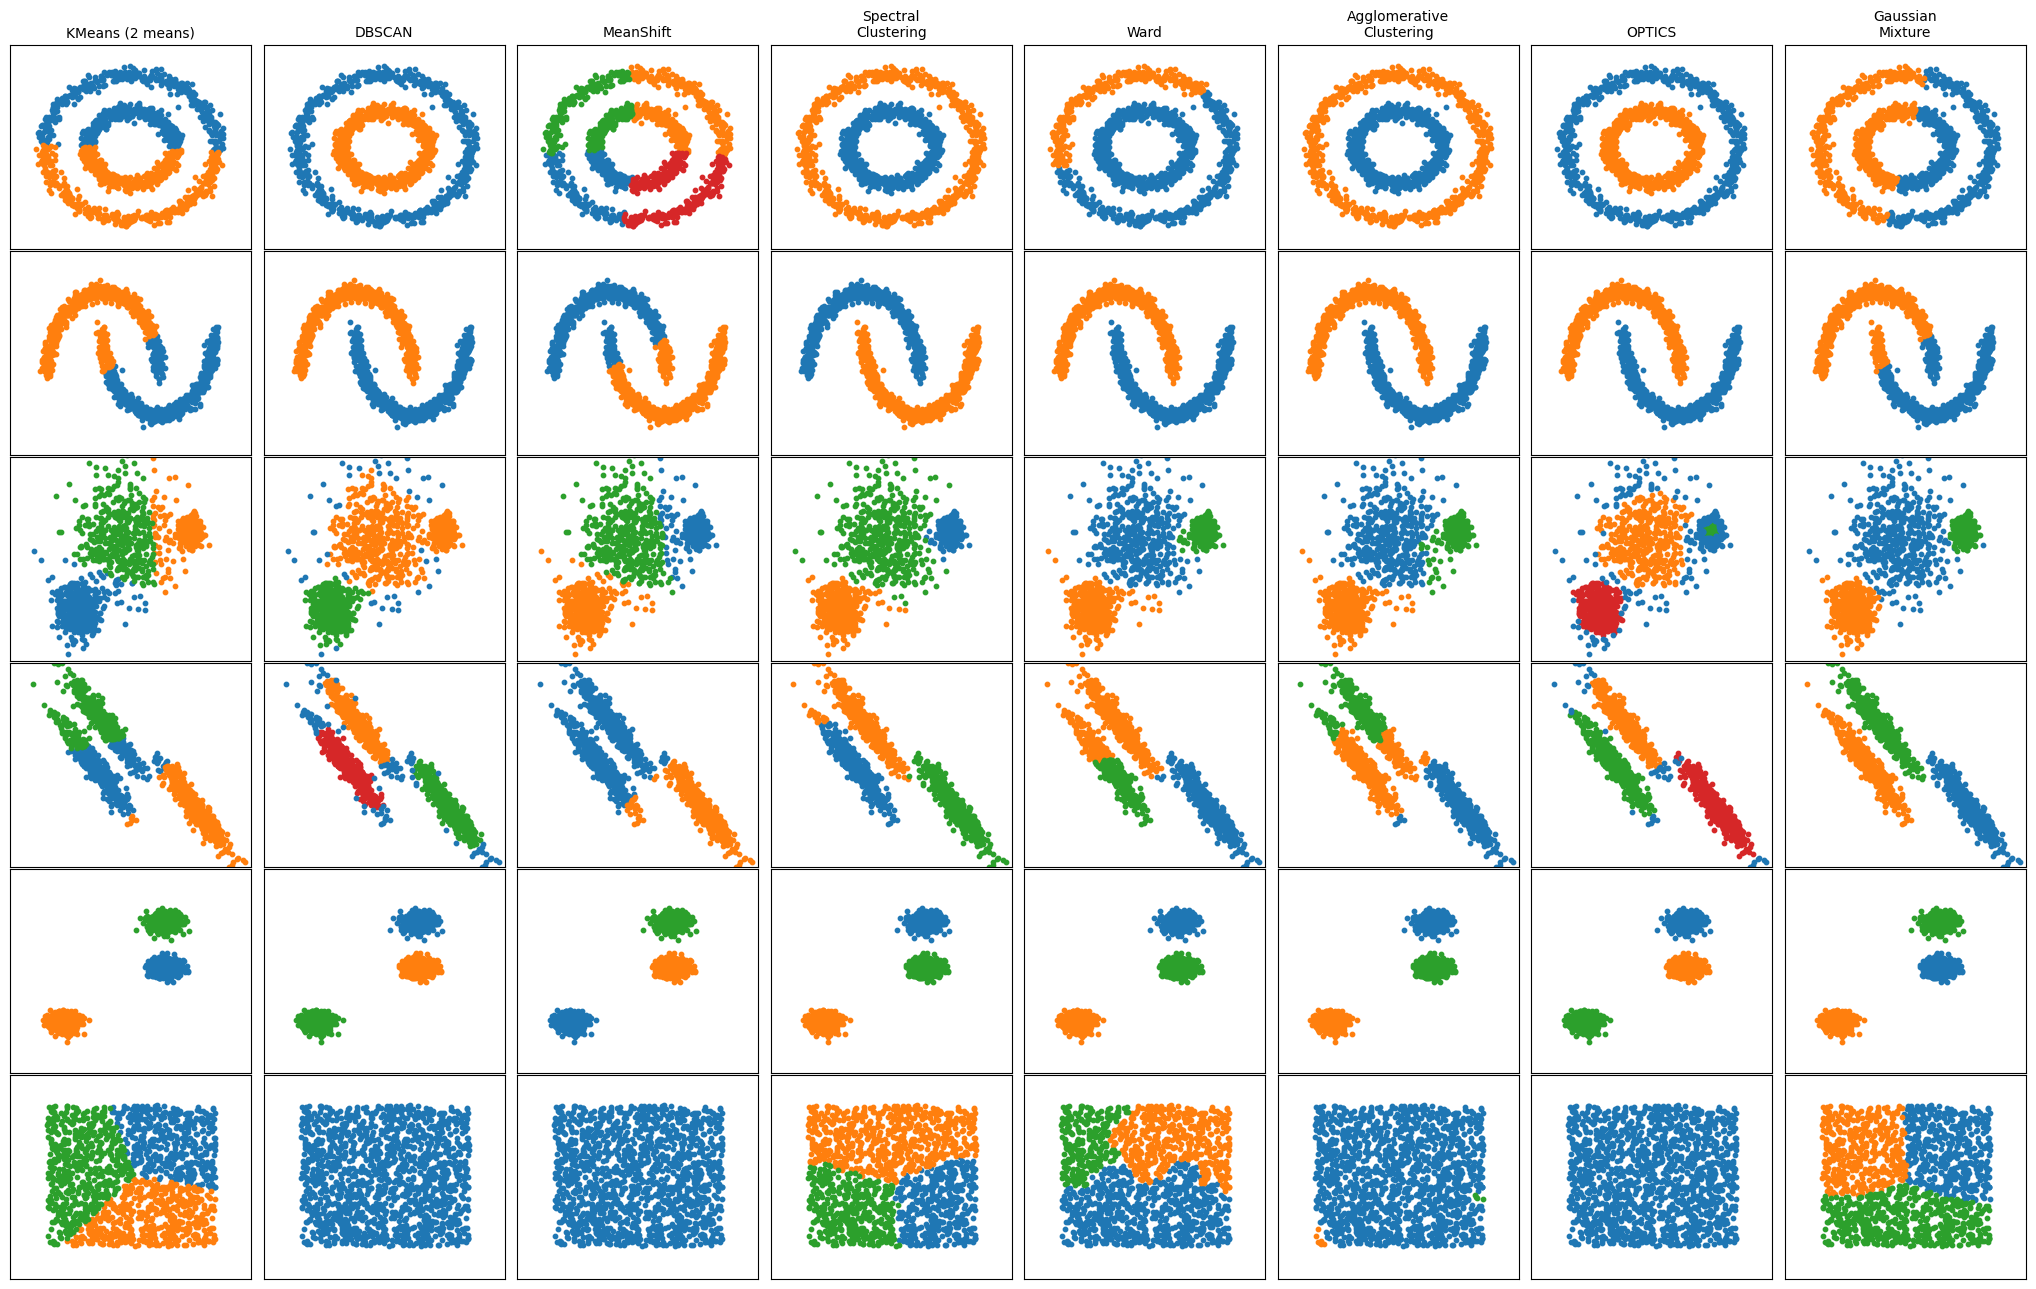

In [20]:
np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

dataset_list = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        if name == "MeanShift":
            algorithm.set_params(bandwidth=bandwidth)
        elif name == "Spectral\nClustering":
            algorithm.set_params(n_clusters=params["n_clusters"])
        elif name in ("Ward", "Agglomerative\nClustering"):
            algorithm.set_params(n_clusters=params["n_clusters"], connectivity=connectivity)
        elif name == "DBSCAN":
            algorithm.set_params(eps=params["eps"], min_samples=params["min_samples"])
        elif name == "OPTICS":
            algorithm.set_params(min_samples=params["min_samples"], xi=params["xi"],
                                 min_cluster_size=params["min_cluster_size"])
        elif name == "Gaussian\nMixture":
            algorithm.set_params(n_components=params["n_clusters"])
        elif name == "KMeans (2 means)":
            algorithm.set_params(n_clusters=params["n_clusters"])

        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        elif hasattr(algorithm, 'predict'):
            y_pred = algorithm.predict(X)
        else:
            y_pred = algorithm.fit_predict(X)

        plt.subplot(len(dataset_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=10)
        unique_labels = set(y_pred)
        colors = [plt.cm.tab10(i) for i in range(len(unique_labels))] + ['#000000']
        color_map = {label: colors[i] for i, label in enumerate(sorted(unique_labels))}
        for label in unique_labels:
            mask = y_pred == label
            plt.scatter(X[mask, 0], X[mask, 1], s=10, color=color_map[label])
        plt.xticks(())
        plt.yticks(())
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plot_num += 1

plt.show()
        